In [4]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6205 (delta 1), reused 3 (delta 1), pack-reused 6196
Receiving objects: 100% (6205/6205), 13.48 MiB | 2.90 MiB/s, done.
Resolving deltas: 100% (4196/4196), done.


In [5]:
%cd keras-retinanet/
!pip install .

/home/raj/projects/amenity_detection/keras-retinanet
Processing /home/raj/projects/amenity_detection/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp38-cp38-linux_x86_64.whl size=173973 sha256=8e496f5c17e9b5b9c46e61fd5abfe0d3bc2e7230baadf42012db7e6428ec66cc
  Stored in directory: /home/raj/.cache/pip/wheels/29/06/82/aefb539c676571c3eb69027deeb114212ffe5609df37efa1cc
Successfully built keras-retinanet
  Attempting uninstall: keras-retinanet
    Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinanet-1.0.0:
      Successfully uninstalled keras-retinanet-1.0.0


In [6]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/home/raj/anaconda3/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/raj/projects/amenity_detection/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/keras_retinanet
creating build/temp.linux-x86_64-3.8/keras_retinanet/utils
gcc -pthread -B /home/raj/anaconda3/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/raj/anaconda3/include/python3.8 -I/home/raj/anaconda3/lib/python3.8/site-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_6

In [7]:
# !pip install keras==2.3.1
# !pip install tensorflow==2.1.0

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image
import glob

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

In [9]:
classes = ['Bed','Microwave','Refrigerator','Sink','Toilet']
with open('classes.csv', 'w') as f:
    for i, class_name in enumerate(classes):
        f.write(f'{class_name},{i}\n')

In [10]:
!head classes.csv

Bed,0
Microwave,1
Refrigerator,2
Sink,3
Toilet,4


In [20]:
import shutil
import math
data_dir = 'train/'
dest = "data/"

path = []
xmin = []
ymin = []
xmax = []
ymax = []
class_ = []
c = 0
for folder in os.listdir(data_dir):
    if(folder == ".ipynb_checkpoints"):
        continue
    for i,file in enumerate(glob.glob(data_dir+folder+"/*.jpg")):
        if(i>400):
            break
        new_file_name = folder+str(i)+".jpg"
        os.rename(file, new_file_name)
        os.system("cp " + data_dir+folder+"/"+ new_file_name + " /"+dest)
        f = open(data_dir+folder + "/Label/" + file.split('/')[-1].replace('.jpg','.txt'), "r")
        for line in f.readlines():
            items = line.split(" ")
            if("oven" in items):
                items.remove("oven")

            path.append(new_file_name)
            class_.append(items[0])
            xmin.append(int(float(items[1])))
            ymin.append(int(float(items[2])))
            xmax.append(int(float(items[3])))
            ymax.append(int(float(items[4].replace('\n',''))))
        f.close()

In [21]:
train_df = pd.DataFrame({'image_name': path,
                         "x_min": xmin,
                         "y_min": ymin,
                         "x_max": xmax,
                         "y_max": ymax,
                         "class_name": class_})

In [22]:
train_df.to_csv('annotations.csv', index=False, header=None)

In [23]:
train_df.shape

(2333, 6)

In [24]:
!head annotations.csv

Microwave oven0.jpg,421,103,605,236,Microwave
Microwave oven1.jpg,54,3,368,251,Microwave
Microwave oven2.jpg,874,3,1023,619,Microwave
Microwave oven3.jpg,0,1,418,303,Microwave
Microwave oven3.jpg,0,315,497,716,Microwave
Microwave oven4.jpg,254,181,427,281,Microwave
Microwave oven5.jpg,430,165,589,369,Microwave
Microwave oven6.jpg,339,11,756,428,Microwave
Microwave oven7.jpg,682,409,839,567,Microwave
Microwave oven8.jpg,565,152,780,283,Microwave


In [28]:
data_dir = 'train/'

path = []
xmin = []
ymin = []
xmax = []
ymax = []
class_ = []
c = 0
for folder in os.listdir(data_dir):
    if(folder == ".ipynb_checkpoints"):
        continue
    for i,file in enumerate(glob.glob(data_dir+folder+"/*.jpg")):
        f = open(data_dir+folder + "/Label/" + file.split('/')[-1].replace('.jpg','.txt'), "r")
        for line in f.readlines():
            items = line.split(" ")
            if("oven" in items):
                items.remove("oven")
            path.append(file)
            class_.append(items[0])
            xmin.append(int(float(items[1])))
            ymin.append(int(float(items[2])))
            xmax.append(int(float(items[3])))
            ymax.append(int(float(items[4].replace('\n',''))))
        f.close()

In [29]:
test_df = pd.DataFrame({'image_name': path,
                         "x_min": xmin,
                         "y_min": ymin,
                         "x_max": xmax,
                         "y_max": ymax,
                         "class_name": class_})

In [30]:
if not os.path.exists('snapshots'):
    os.mkdir('snapshots')
PRETRAINED_MODEL = 'snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

In [233]:
!keras_retinanet/bin/train.py --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 8 \
  --steps 250 \
  --epochs 15 \
  csv annotations.csv classes.csv

2020-10-10 08:26:22.938390: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-10-10 08:26:24.641082: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-10 08:26:24.645966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-10 08:26:24.646458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-10-10 08:26:24.646497: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-10 08:26:24.648133: I t

In [234]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_06.h5  resnet50_csv_12.h5
resnet50_csv_01.h5    resnet50_csv_07.h5  resnet50_csv_13.h5
resnet50_csv_02.h5    resnet50_csv_08.h5  resnet50_csv_14.h5
resnet50_csv_03.h5    resnet50_csv_09.h5  resnet50_csv_15.h5
resnet50_csv_04.h5    resnet50_csv_10.h5
resnet50_csv_05.h5    resnet50_csv_11.h5


In [32]:
from glob import glob
model_paths = glob('snapshots/resnet50_csv_*.h5')
latest_path = sorted(model_paths)[-1]

model = models.load_model(latest_path , backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
    row = line.rstrip().split(',')
    label_map[int(row[1])] = row[0]

In [33]:
def show_image_with_predictions(df, threshold):
  # choose a random image
  row = df.sample()
  filepath = row['image_name'].values[0]
  print("filepath:", filepath)

  # get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  # plot true boxes
  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )

  # standardize box coordinates
  boxes /= scale
  print(boxes)
  
  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=(0,255,0))

    class_name = label_map[label]
    print(class_name)
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


In [34]:
plt.rcParams['figure.figsize'] = [20, 10]

filepath: Toilet21.jpg
im.shape: (683, 1024, 3)
[329, 513, 477, 656]
[371, 577, 533, 681]
[[[ 3.18926056e+02  4.99595306e+02  5.33030334e+02  6.82146301e+02]
  [ 5.50499329e+02  5.05269012e+02  1.00281744e+03  6.82146301e+02]
  [ 3.16313812e+02  5.05861389e+02  5.08438324e+02  6.73826355e+02]
  ...
  [-8.53750050e-01 -8.53750050e-01 -8.53750050e-01 -8.53750050e-01]
  [-8.53750050e-01 -8.53750050e-01 -8.53750050e-01 -8.53750050e-01]
  [-8.53750050e-01 -8.53750050e-01 -8.53750050e-01 -8.53750050e-01]]]
Toilet


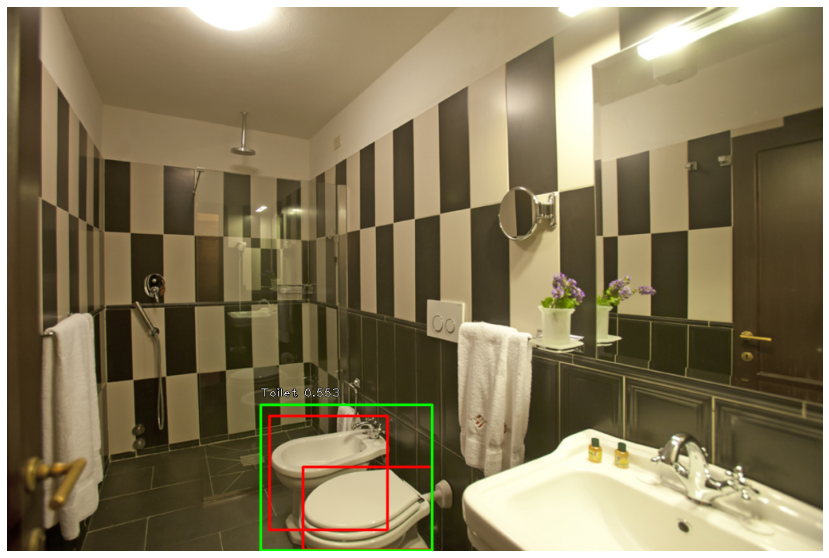

In [46]:
show_image_with_predictions(train_df, threshold=0.5)

filepath: train/Refrigerator/02b7497bfae4a59f.jpg
im.shape: (687, 1024, 3)
[119, 184, 254, 686]
[[[ 73.39728  169.32542  281.70605  684.88464 ]
  [415.61957  280.47504  547.0161   361.44235 ]
  [119.313805 196.33208  249.38806  483.32574 ]
  ...
  [ -0.85875   -0.85875   -0.85875   -0.85875 ]
  [ -0.85875   -0.85875   -0.85875   -0.85875 ]
  [ -0.85875   -0.85875   -0.85875   -0.85875 ]]]
Refrigerator
Microwave


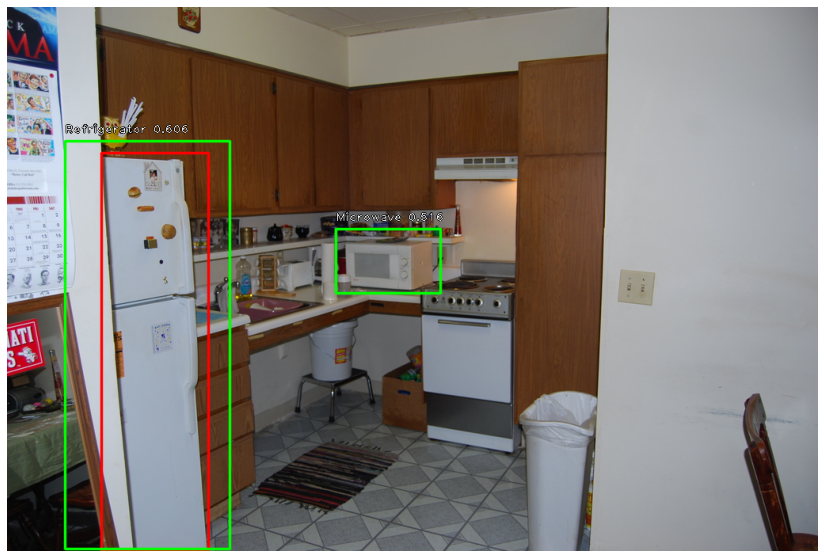

In [42]:
show_image_with_predictions(test_df, threshold=0.5)